# Article Similarity Project

## Step 1. Set-up

In [2]:
# First, import the relevant modules.

#Visuals
import pyLDAvis
import pyLDAvis.gensim 
%matplotlib inline  
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

#Tools
import csv
import glob
import os
import sys
import pandas as pd 
import numpy as np
import nltk
from nltk.corpus import stopwords
import gensim
from gensim.models import LdaModel
from gensim import models, corpora, similarities
import re
from nltk.stem.porter import PorterStemmer
import time
from nltk import FreqDist
from scipy.stats import entropy
import xmltodict

c:\python37-32\lib\site-packages\nltk\decorators.py:68: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  regargs, varargs, varkwargs, defaults, formatvalue=lambda value: ""
c:\python37-32\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


## Step 2. Reading and Cleaning Data

In [3]:
#Here, we set up the directory of the xml file we downloaded from the database
filename = "C:\\Users\\18059\\Box Sync\\pythonprojects\\LDA_equityproject\\equity2.xml"

# Open up the xml file, and convert to a dictionary
with open(filename, encoding="utf8") as fd:
    doc = xmltodict.parse(fd.read())

#The xml file has many, many subtags. This helps flatten so we can get the more relevant information.
def flatten_dict(dd, separator='_', prefix=''):
    return { prefix + separator + k if prefix else k : v
             for kk, vv in dd.items()
             for k, v in flatten_dict(vv, separator, kk).items()
             } if isinstance(dd, dict) else { prefix : dd }

#Apply the flatten function to the dictionary created above.
flattened_doc = [flatten_dict(x) for x in doc['records']['rec']]

#Put all of this information into a dataframe.
data1 = pd.DataFrame(flattened_doc)

In [4]:
data1.columns

Index(['@resultID', 'header_@longDbName', 'header_@shortDbName',
       'header_@uiTerm', 'header_controlInfo_artinfo_ab',
       'header_controlInfo_artinfo_aug',
       'header_controlInfo_artinfo_aug_affil',
       'header_controlInfo_artinfo_aug_au',
       'header_controlInfo_artinfo_doctype',
       'header_controlInfo_artinfo_formats', 'header_controlInfo_artinfo_ppct',
       'header_controlInfo_artinfo_ppf', 'header_controlInfo_artinfo_pubtype',
       'header_controlInfo_artinfo_sug_subj',
       'header_controlInfo_artinfo_sug_subj_#text',
       'header_controlInfo_artinfo_sug_subj_@type',
       'header_controlInfo_artinfo_tig_atl', 'header_controlInfo_bkinfo',
       'header_controlInfo_jinfo_issn', 'header_controlInfo_jinfo_jtl',
       'header_controlInfo_language_#text',
       'header_controlInfo_language_@code',
       'header_controlInfo_pubinfo_dt_#text',
       'header_controlInfo_pubinfo_dt_@day',
       'header_controlInfo_pubinfo_dt_@month',
       'header_cont

In [5]:
pd.set_option('display.max_columns', None)

In [6]:
data1.head()

,@resultID,header_@longDbName,header_@shortDbName,header_@uiTerm,header_controlInfo_artinfo_ab,header_controlInfo_artinfo_aug,header_controlInfo_artinfo_aug_affil,header_controlInfo_artinfo_aug_au,header_controlInfo_artinfo_doctype,header_controlInfo_artinfo_formats,header_controlInfo_artinfo_ppct,header_controlInfo_artinfo_ppf,header_controlInfo_artinfo_pubtype,header_controlInfo_artinfo_sug_subj,header_controlInfo_artinfo_sug_subj_#text,header_controlInfo_artinfo_sug_subj_@type,header_controlInfo_artinfo_tig_atl,header_controlInfo_bkinfo,header_controlInfo_jinfo_issn,header_controlInfo_jinfo_jtl,header_controlInfo_language_#text,header_controlInfo_language_@code,header_controlInfo_pubinfo_dt_#text,header_controlInfo_pubinfo_dt_@day,header_controlInfo_pubinfo_dt_@month,header_controlInfo_pubinfo_dt_@year,header_controlInfo_pubinfo_iid,header_controlInfo_pubinfo_vid,header_displayInfo_pLink_url
0,1,Education Abstracts (H.W. Wilson),eax,135309477,This study assesses the reliability of two obs...,NaN,"University of California, Los Angeles, USA","[Nava, Imelda, Park, Jaime, Dockterman, Danny,...",Article,None,16,139,Academic Journal,"[{'@type': 'thes', '#text': 'Mathematics educa...",NaN,NaN,Measuring Teaching Quality of Secondary Mathem...,None,00224871,Journal of Teacher Education,English,eng,Mar/Apr2019,01,03,2019,2,70,http://proxy.lib.umich.edu/login?url=http://se...
1,2,Education Abstracts (H.W. Wilson),eax,137159246,"In their commentary, ""Toward a Framework for R...",NaN,"[University of Washington, University of Illin...","[Barajas-López, Filiberto, Larnell, Gregory V.]",Article,None,13,349,Academic Journal,NaN,NaN,NaN,Unpacking the Links Between Equitable Teaching...,None,00218251,Journal for Research in Mathematics Education,English,eng,Jul2019,01,07,2019,4,50,http://proxy.lib.umich.edu/login?url=http://se...
2,3,Education Abstracts (H.W. Wilson),eax,136109754,Mathematics classrooms are increasingly becomi...,NaN,"University of Tennessee, Knoxville","Harper, Frances K.",Article,None,43,268,Academic Journal,NaN,NaN,NaN,A Qualitative Metasynthesis of Teaching Mathem...,None,00218251,Journal for Research in Mathematics Education,English,eng,May2019,01,05,2019,3,50,http://proxy.lib.umich.edu/login?url=http://se...
3,4,Education Abstracts (H.W. Wilson),eax,112740992,The article presents the result of the qualita...,NaN,"[Assistant professor of mathematics, Teaching ...","[Vomvoridi-Ivanovic, Eugenia, McLeman, Laura]",Article,None,18,83,Academic Journal,"[{'@type': 'thes', '#text': 'Qualitative resea...",NaN,NaN,Mathematics Teacher Educators Focusing on Equi...,None,07375328,Teacher Education Quarterly,English,eng,Fall2015,01,10,2015,4,42,http://proxy.lib.umich.edu/login?url=http://se...
4,5,Education Abstracts (H.W. Wilson),eax,84964058,This case study examines the practice of a ful...,NaN,University of Cincinnati,"Gregson, Susan A.",Article,None,35,164,Academic Journal,"[{'@type': 'thes', '#text': 'Mathematics educa...",NaN,NaN,Negotiating Social Justice Teaching: One Full-...,None,00218251,Journal for Research in Mathematics Education,English,eng,Jan2013,01,01,2013,1,44,http://proxy.lib.umich.edu/login?url=http://se...


In [7]:
df = data1[['@resultID', 'header_controlInfo_jinfo_jtl', 'header_controlInfo_artinfo_tig_atl','header_controlInfo_artinfo_ab', 
            'header_controlInfo_artinfo_aug_au', 'header_controlInfo_pubinfo_dt_#text']]

In [8]:
df.columns = ['article_ID','Journal_Title', 'Article_Title', 'Article_Abstract',
                     'Authors','Year_of_Publication']

In [9]:
df.head()

,article_ID,Journal_Title,Article_Title,Article_Abstract,Authors,Year_of_Publication
0,1,Journal of Teacher Education,Measuring Teaching Quality of Secondary Mathem...,This study assesses the reliability of two obs...,"[Nava, Imelda, Park, Jaime, Dockterman, Danny,...",Mar/Apr2019
1,2,Journal for Research in Mathematics Education,Unpacking the Links Between Equitable Teaching...,"In their commentary, ""Toward a Framework for R...","[Barajas-López, Filiberto, Larnell, Gregory V.]",Jul2019
2,3,Journal for Research in Mathematics Education,A Qualitative Metasynthesis of Teaching Mathem...,Mathematics classrooms are increasingly becomi...,"Harper, Frances K.",May2019
3,4,Teacher Education Quarterly,Mathematics Teacher Educators Focusing on Equi...,The article presents the result of the qualita...,"[Vomvoridi-Ivanovic, Eugenia, McLeman, Laura]",Fall2015
4,5,Journal for Research in Mathematics Education,Negotiating Social Justice Teaching: One Full-...,This case study examines the practice of a ful...,"Gregson, Susan A.",Jan2013


In [10]:
df['Year_of_Publication'].replace(regex=True,inplace=True,to_replace=r'\D',value=r'')

c:\python37-32\lib\site-packages\pandas\core\generic.py:6586: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [11]:
df.head()

,article_ID,Journal_Title,Article_Title,Article_Abstract,Authors,Year_of_Publication
0,1,Journal of Teacher Education,Measuring Teaching Quality of Secondary Mathem...,This study assesses the reliability of two obs...,"[Nava, Imelda, Park, Jaime, Dockterman, Danny,...",2019
1,2,Journal for Research in Mathematics Education,Unpacking the Links Between Equitable Teaching...,"In their commentary, ""Toward a Framework for R...","[Barajas-López, Filiberto, Larnell, Gregory V.]",2019
2,3,Journal for Research in Mathematics Education,A Qualitative Metasynthesis of Teaching Mathem...,Mathematics classrooms are increasingly becomi...,"Harper, Frances K.",2019
3,4,Teacher Education Quarterly,Mathematics Teacher Educators Focusing on Equi...,The article presents the result of the qualita...,"[Vomvoridi-Ivanovic, Eugenia, McLeman, Laura]",2015
4,5,Journal for Research in Mathematics Education,Negotiating Social Justice Teaching: One Full-...,This case study examines the practice of a ful...,"Gregson, Susan A.",2013


In [12]:
df = df.astype({"Authors": str,"Article_Abstract": str, "Article_Title": str})

In [13]:
df.head()

,article_ID,Journal_Title,Article_Title,Article_Abstract,Authors,Year_of_Publication
0,1,Journal of Teacher Education,Measuring Teaching Quality of Secondary Mathem...,This study assesses the reliability of two obs...,"['Nava, Imelda', 'Park, Jaime', 'Dockterman, D...",2019
1,2,Journal for Research in Mathematics Education,Unpacking the Links Between Equitable Teaching...,"In their commentary, ""Toward a Framework for R...","['Barajas-López, Filiberto', 'Larnell, Gregory...",2019
2,3,Journal for Research in Mathematics Education,A Qualitative Metasynthesis of Teaching Mathem...,Mathematics classrooms are increasingly becomi...,"Harper, Frances K.",2019
3,4,Teacher Education Quarterly,Mathematics Teacher Educators Focusing on Equi...,The article presents the result of the qualita...,"['Vomvoridi-Ivanovic, Eugenia', 'McLeman, Laura']",2015
4,5,Journal for Research in Mathematics Education,Negotiating Social Justice Teaching: One Full-...,This case study examines the practice of a ful...,"Gregson, Susan A.",2013


In [14]:
# In case I want to get rid of lists.
#df = df.applymap(lambda x: x if not isinstance(x, list) else x[0] if len(x) else '')

In [15]:
df['Authors'][1]

"['Barajas-López, Filiberto', 'Larnell, Gregory V.']"

In [16]:
df['Authors'][0]

"['Nava, Imelda', 'Park, Jaime', 'Dockterman, Danny', 'Kawasaki, Jarod', 'Schweig, Jon', 'Quartz, Karen Hunter', 'Martinez, Jose Felipe']"

In [17]:
df.head()

,article_ID,Journal_Title,Article_Title,Article_Abstract,Authors,Year_of_Publication
0,1,Journal of Teacher Education,Measuring Teaching Quality of Secondary Mathem...,This study assesses the reliability of two obs...,"['Nava, Imelda', 'Park, Jaime', 'Dockterman, D...",2019
1,2,Journal for Research in Mathematics Education,Unpacking the Links Between Equitable Teaching...,"In their commentary, ""Toward a Framework for R...","['Barajas-López, Filiberto', 'Larnell, Gregory...",2019
2,3,Journal for Research in Mathematics Education,A Qualitative Metasynthesis of Teaching Mathem...,Mathematics classrooms are increasingly becomi...,"Harper, Frances K.",2019
3,4,Teacher Education Quarterly,Mathematics Teacher Educators Focusing on Equi...,The article presents the result of the qualita...,"['Vomvoridi-Ivanovic, Eugenia', 'McLeman, Laura']",2015
4,5,Journal for Research in Mathematics Education,Negotiating Social Justice Teaching: One Full-...,This case study examines the practice of a ful...,"Gregson, Susan A.",2013


In [18]:
df.dropna()

,article_ID,Journal_Title,Article_Title,Article_Abstract,Authors,Year_of_Publication
0,1,Journal of Teacher Education,Measuring Teaching Quality of Secondary Mathem...,This study assesses the reliability of two obs...,"['Nava, Imelda', 'Park, Jaime', 'Dockterman, D...",2019
1,2,Journal for Research in Mathematics Education,Unpacking the Links Between Equitable Teaching...,"In their commentary, ""Toward a Framework for R...","['Barajas-López, Filiberto', 'Larnell, Gregory...",2019
2,3,Journal for Research in Mathematics Education,A Qualitative Metasynthesis of Teaching Mathem...,Mathematics classrooms are increasingly becomi...,"Harper, Frances K.",2019
3,4,Teacher Education Quarterly,Mathematics Teacher Educators Focusing on Equi...,The article presents the result of the qualita...,"['Vomvoridi-Ivanovic, Eugenia', 'McLeman, Laura']",2015
4,5,Journal for Research in Mathematics Education,Negotiating Social Justice Teaching: One Full-...,This case study examines the practice of a ful...,"Gregson, Susan A.",2013
5,6,"African Journal of Research in Mathematics, Sc...",Social Relationships between Teachers and Lear...,"In recent years, the notion of equity has beco...","Gardee, Aarifah",2019
6,7,Cultural Studies of Science Education,Expanding and enacting transformative meanings...,"In this paper, we provide a conceptual critiqu...","['Rodriguez, Alberto J.', 'Morrison, Deb']",2019
7,8,"Pedagogy, Culture & Society",Critical relationships between teachers and le...,This article draws on critical theories and pe...,"Wright, Pete",2017
8,9,American Educational Research Journal,Toward Equity in Mathematics Education for Stu...,This case study documents a professional learn...,"['Tan, Paulo', 'Thorius, Kathleen King']",2019
9,10,International Journal of Science Education,A STEM extended learning project to raise awar...,Governments worldwide are advocating for STEM ...,"['Mildenhall, P.', 'Cowie, B.', 'Sherriff, B.']",2019


In [19]:
#df = df.drop(df[df.Article_Abstract == 'nan'].index)

In [20]:
#df

### Next, we create functions to clean and tokenize our data.

In [21]:
def initial_clean(text):
    """
    Function to clean text of websites, email addresess and any punctuation
    We also lower case the text
    """
    text = re.sub("((\S+)?(http(s)?)(\S+))|((\S+)?(www)(\S+))|((\S+)?(\@)(\S+)?)", " ", text)
    text = re.sub("[^a-zA-Z ]", "", text)
    text = text.lower() # lower case the text
    text = nltk.word_tokenize(text)
    return text

stop_words = stopwords.words('english') + ['student', 'mathematics', 'teacher', 'education', 'school', 'learn', 'teacher']
def remove_stop_words(text):
    """
    Function that removes all stopwords from text
    """
    return [word for word in text if word not in stop_words]

stemmer = PorterStemmer()
def stem_words(text):
    """
    Function to stem words, so plural and singular are treated the same
    """
    try:
        text = [stemmer.stem(word) for word in text]
        text = [word for word in text if len(word) > 1] # make sure we have no 1 letter words
    except IndexError: # the word "oed" broke this, so needed try except
        pass
    return text

def apply_all(text):
    """
    This function applies all the functions above into one
    """
    return stem_words(remove_stop_words(initial_clean(text)))

<>:6: DeprecationWarning: invalid escape sequence \S
<>:6: DeprecationWarning: invalid escape sequence \S
<>:6: DeprecationWarning: invalid escape sequence \S
<ipython-input-21-05cc5cba29f8>:6: DeprecationWarning: invalid escape sequence \S
  text = re.sub("((\S+)?(http(s)?)(\S+))|((\S+)?(www)(\S+))|((\S+)?(\@)(\S+)?)", " ", text)


In [23]:
# Clean text and title and create new column "tokenized"
t1 = time.time()
df['tokenized_abstracts'] = df['Article_Abstract'].apply(apply_all) + df['Article_Title'].apply(apply_all)
t2 = time.time()
print("Time to clean and tokenize", len(df), "articles:", (t2-t1)/60, "min")

Time to clean and tokenize 473 articles: 0.042336249351501466 min


In [24]:
too_common = ['student', 'mathemat', 'teacher', 'educ', 'school', 'learn', 'teach']
df['tokenized_abstracts'].apply(lambda x: [item for item in x if item not in too_common])

0      [studi, assess, reliabl, two, observ, rubric, ...
1      [commentari, toward, framework, research, link...
2      [classroom, increasingli, becom, site, investi...
3      [articl, present, result, qualit, studi, mte, ...
4      [case, studi, examin, practic, fulltim, social...
5      [recent, year, notion, equiti, becom, increasi...
6      [paper, provid, conceptu, critiqu, variou, con...
7      [articl, draw, critic, theori, perspect, expla...
8      [case, studi, document, profession, commun, pl...
9      [govern, worldwid, advoc, stem, curricula, ess...
10     [mixedmethod, studi, examin, relationship, cla...
11     [role, languag, increasingli, highlight, stand...
12     [mani, effort, made, reach, equiti, especi, re...
13     [paper, report, studi, aim, address, challeng,...
14     [articl, outlin, sever, form, instruct, practi...
15     [articl, author, present, analysi, two, view, ...
16     [galvan, organ, commun, movement, mass, incarc...
17     [common, core, state, st

In [25]:
df.head()

,article_ID,Journal_Title,Article_Title,Article_Abstract,Authors,Year_of_Publication,tokenized_abstracts
0,1,Journal of Teacher Education,Measuring Teaching Quality of Secondary Mathem...,This study assesses the reliability of two obs...,"['Nava, Imelda', 'Park, Jaime', 'Dockterman, D...",2019,"[studi, assess, reliabl, two, observ, rubric, ..."
1,2,Journal for Research in Mathematics Education,Unpacking the Links Between Equitable Teaching...,"In their commentary, ""Toward a Framework for R...","['Barajas-López, Filiberto', 'Larnell, Gregory...",2019,"[commentari, toward, framework, research, link..."
2,3,Journal for Research in Mathematics Education,A Qualitative Metasynthesis of Teaching Mathem...,Mathematics classrooms are increasingly becomi...,"Harper, Frances K.",2019,"[classroom, increasingli, becom, site, investi..."
3,4,Teacher Education Quarterly,Mathematics Teacher Educators Focusing on Equi...,The article presents the result of the qualita...,"['Vomvoridi-Ivanovic, Eugenia', 'McLeman, Laura']",2015,"[articl, present, result, qualit, studi, educ,..."
4,5,Journal for Research in Mathematics Education,Negotiating Social Justice Teaching: One Full-...,This case study examines the practice of a ful...,"Gregson, Susan A.",2013,"[case, studi, examin, practic, fulltim, social..."


In [26]:
# First, get a list of all words
all_words = [word for item in list(df['tokenized_abstracts']) for word in item]
# use nltk fdist to get a frequency distribution of all words
fdist = FreqDist(all_words)
len(fdist) # number of unique words

4764

In [27]:
k = 1000
top_k_words = fdist.most_common(k)
top_k_words[-10:]

[('ultim', 8),
 ('concret', 8),
 ('vision', 8),
 ('sinc', 8),
 ('averag', 8),
 ('correl', 8),
 ('ipad', 8),
 ('pilot', 8),
 ('cluster', 8),
 ('london', 8)]

In [28]:
# document length
df['doc_len'] = df['tokenized_abstracts'].apply(lambda x: len(x))
doc_lengths = list(df['doc_len'])
df.drop(labels='doc_len', axis=1, inplace=True)

print("length of list:",len(doc_lengths),
      "\naverage document length", np.average(doc_lengths),
      "\nminimum document length", min(doc_lengths),
      "\nmaximum document length", max(doc_lengths))

length of list: 473 
average document length 102.39957716701903 
minimum document length 3 
maximum document length 3132


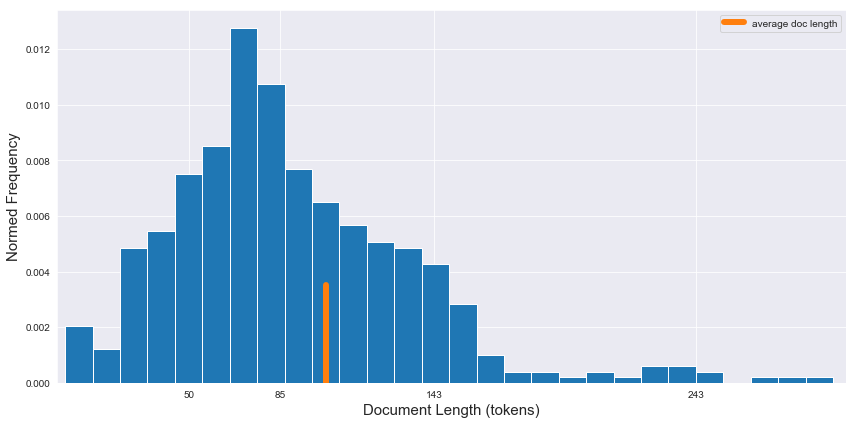

In [32]:
# plot a histogram of document length
num_bins = 300
fig, ax = plt.subplots(figsize=(12,6));
# the histogram of the data
n, bins, patches = ax.hist(doc_lengths, num_bins, density=1)
ax.set_xlabel('Document Length (tokens)', fontsize=15)
ax.set_ylabel('Normed Frequency', fontsize=15)
ax.grid()
ax.set_xticks(np.logspace(start=np.log10(50),stop=np.log10(2000),num=8, base=10.0))
plt.xlim(0,300)
ax.plot([np.average(doc_lengths) for i in np.linspace(0.0,0.0035,300)], np.linspace(0.0,0.0035,300), '-',
        label='average doc length', linewidth=6)
ax.legend()
ax.grid()
fig.tight_layout()
plt.show()

In [33]:
# only keep articles with more than 10 tokens, otherwise too short
df = df[df['tokenized_abstracts'].map(len) >= 10]
# make sure all tokenized items are lists
df = df[df['tokenized_abstracts'].map(type) == list]
df.reset_index(drop=True,inplace=True)
print("After cleaning and excluding short aticles, the dataframe now has:", len(df), "articles")

After cleaning and excluding short aticles, the dataframe now has: 464 articles


In [34]:
# create a mask of binary values
msk = np.random.rand(len(df)) < 0.80

train_df = df[msk]
train_df.reset_index(drop=True,inplace=True)

test_df = df[~msk]
test_df.reset_index(drop=True,inplace=True)

In [35]:
df.head(100)

,article_ID,Journal_Title,Article_Title,Article_Abstract,Authors,Year_of_Publication,tokenized_abstracts
0,1,Journal of Teacher Education,Measuring Teaching Quality of Secondary Mathem...,This study assesses the reliability of two obs...,"['Nava, Imelda', 'Park, Jaime', 'Dockterman, D...",2019,"[studi, assess, reliabl, two, observ, rubric, ..."
1,2,Journal for Research in Mathematics Education,Unpacking the Links Between Equitable Teaching...,"In their commentary, ""Toward a Framework for R...","['Barajas-López, Filiberto', 'Larnell, Gregory...",2019,"[commentari, toward, framework, research, link..."
2,3,Journal for Research in Mathematics Education,A Qualitative Metasynthesis of Teaching Mathem...,Mathematics classrooms are increasingly becomi...,"Harper, Frances K.",2019,"[classroom, increasingli, becom, site, investi..."
3,4,Teacher Education Quarterly,Mathematics Teacher Educators Focusing on Equi...,The article presents the result of the qualita...,"['Vomvoridi-Ivanovic, Eugenia', 'McLeman, Laura']",2015,"[articl, present, result, qualit, studi, educ,..."
4,5,Journal for Research in Mathematics Education,Negotiating Social Justice Teaching: One Full-...,This case study examines the practice of a ful...,"Gregson, Susan A.",2013,"[case, studi, examin, practic, fulltim, social..."
5,6,"African Journal of Research in Mathematics, Sc...",Social Relationships between Teachers and Lear...,"In recent years, the notion of equity has beco...","Gardee, Aarifah",2019,"[recent, year, notion, equiti, becom, increasi..."
6,7,Cultural Studies of Science Education,Expanding and enacting transformative meanings...,"In this paper, we provide a conceptual critiqu...","['Rodriguez, Alberto J.', 'Morrison, Deb']",2019,"[paper, provid, conceptu, critiqu, variou, con..."
7,8,"Pedagogy, Culture & Society",Critical relationships between teachers and le...,This article draws on critical theories and pe...,"Wright, Pete",2017,"[articl, draw, critic, theori, perspect, expla..."
8,9,American Educational Research Journal,Toward Equity in Mathematics Education for Stu...,This case study documents a professional learn...,"['Tan, Paulo', 'Thorius, Kathleen King']",2019,"[case, studi, document, profession, learn, com..."
9,10,International Journal of Science Education,A STEM extended learning project to raise awar...,Governments worldwide are advocating for STEM ...,"['Mildenhall, P.', 'Cowie, B.', 'Sherriff, B.']",2019,"[govern, worldwid, advoc, stem, curricula, ess..."


In [36]:
print(len(df),len(train_df),len(test_df))

464 384 80


In [37]:
def train_lda(data):
    """
    This function trains the lda model
    We setup parameters like number of topics, the chunksize to use in Hoffman method
    We also do a few passes of the data since this is a small dataset, so we want the distributions to stabilize
    """
    num_topics = 9
    chunksize = 100
    dictionary = corpora.Dictionary(data['tokenized_abstracts'])
    corpus = [dictionary.doc2bow(doc) for doc in data['tokenized_abstracts']]
    t1 = time.time()
    # low alpha means each document is only represented by a small number of topics, and vice versa
    # low eta means each topic is only represented by a small number of words, and vice versa
    lda = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary,
                   alpha=1e-2, eta=0.5e-2, chunksize=chunksize, minimum_probability=0.0, passes=2)
    t2 = time.time()
    print("Time to train LDA model on ", len(df), "articles: ", (t2-t1)/60, "min")
    return dictionary,corpus,lda

In [38]:
dictionary,corpus,lda = train_lda(train_df)

Time to train LDA model on  464 articles:  0.012865591049194335 min


In [39]:
# show_topics method shows the the top num_words contributing to num_topics number of random topics
lda.show_topics(num_topics=10, num_words=20)

[(0,
  '0.052*"social" + 0.047*"proof" + 0.036*"teach" + 0.035*"teacher" + 0.035*"justic" + 0.032*"student" + 0.032*"lesson" + 0.020*"full" + 0.017*"prepar" + 0.017*"describ" + 0.017*"use" + 0.013*"studi" + 0.013*"elementari" + 0.011*"understand" + 0.011*"mathemat" + 0.010*"experi" + 0.010*"concept" + 0.010*"practic" + 0.010*"learn" + 0.010*"difficulti"'),
 (1,
  '0.025*"math" + 0.020*"children" + 0.017*"student" + 0.013*"instruct" + 0.013*"practic" + 0.012*"parent" + 0.012*"countri" + 0.011*"issu" + 0.011*"achiev" + 0.010*"reform" + 0.010*"part" + 0.009*"literaci" + 0.009*"skill" + 0.009*"abil" + 0.009*"one" + 0.009*"social" + 0.009*"special" + 0.008*"cultur" + 0.008*"learn" + 0.008*"teacher"'),
 (2,
  '0.041*"scienc" + 0.029*"student" + 0.019*"stem" + 0.016*"cultur" + 0.015*"program" + 0.014*"classroom" + 0.012*"practic" + 0.012*"teach" + 0.011*"particip" + 0.010*"studi" + 0.010*"articl" + 0.010*"develop" + 0.009*"learn" + 0.009*"issu" + 0.009*"technolog" + 0.007*"girl" + 0.007*"clas

In [40]:
lda.show_topic(topicid=5, topn=20)

[('languag', 0.07546113),
 ('technic', 0.07542919),
 ('cycl', 0.05101121),
 ('career', 0.03383572),
 ('youth', 0.028885303),
 ('regularli', 0.024236882),
 ('vocabulari', 0.020039873),
 ('make', 0.019733561),
 ('nondomin', 0.017220058),
 ('develop', 0.016618026),
 ('six', 0.015888631),
 ('precis', 0.014526921),
 ('engag', 0.014304636),
 ('practic', 0.014182066),
 ('equityori', 0.013216337),
 ('figur', 0.011968412),
 ('studi', 0.011919918),
 ('mathemat', 0.011531104),
 ('upon', 0.0107282335),
 ('longitudin', 0.010675989)]

In [41]:
# select and article at random from train_df
random_article_index = np.random.randint(len(train_df))
bow = dictionary.doc2bow(train_df.iloc[random_article_index,6])
print(random_article_index)

330


In [44]:
train_df.head(40)

,article_ID,Journal_Title,Article_Title,Article_Abstract,Authors,Year_of_Publication,tokenized_abstracts
0,1,Journal of Teacher Education,Measuring Teaching Quality of Secondary Mathem...,This study assesses the reliability of two obs...,"['Nava, Imelda', 'Park, Jaime', 'Dockterman, D...",2019,"[studi, assess, reliabl, two, observ, rubric, ..."
1,2,Journal for Research in Mathematics Education,Unpacking the Links Between Equitable Teaching...,"In their commentary, ""Toward a Framework for R...","['Barajas-López, Filiberto', 'Larnell, Gregory...",2019,"[commentari, toward, framework, research, link..."
2,3,Journal for Research in Mathematics Education,A Qualitative Metasynthesis of Teaching Mathem...,Mathematics classrooms are increasingly becomi...,"Harper, Frances K.",2019,"[classroom, increasingli, becom, site, investi..."
3,6,"African Journal of Research in Mathematics, Sc...",Social Relationships between Teachers and Lear...,"In recent years, the notion of equity has beco...","Gardee, Aarifah",2019,"[recent, year, notion, equiti, becom, increasi..."
4,7,Cultural Studies of Science Education,Expanding and enacting transformative meanings...,"In this paper, we provide a conceptual critiqu...","['Rodriguez, Alberto J.', 'Morrison, Deb']",2019,"[paper, provid, conceptu, critiqu, variou, con..."
5,8,"Pedagogy, Culture & Society",Critical relationships between teachers and le...,This article draws on critical theories and pe...,"Wright, Pete",2017,"[articl, draw, critic, theori, perspect, expla..."
6,9,American Educational Research Journal,Toward Equity in Mathematics Education for Stu...,This case study documents a professional learn...,"['Tan, Paulo', 'Thorius, Kathleen King']",2019,"[case, studi, document, profession, learn, com..."
7,10,International Journal of Science Education,A STEM extended learning project to raise awar...,Governments worldwide are advocating for STEM ...,"['Mildenhall, P.', 'Cowie, B.', 'Sherriff, B.']",2019,"[govern, worldwid, advoc, stem, curricula, ess..."
8,11,"Journal of Language, Identity & Education",Mathematical Classroom Discussion as an Equita...,This mixed-method study examines the relations...,"['Banes, Leslie C.', 'Ambrose, Rebecca C.', 'B...",2018,"[mixedmethod, studi, examin, relationship, cla..."
9,12,Mathematical Thinking & Learning,A study of early career teachers' practices re...,The role of language in mathematics teaching a...,"['Turner, Erin', 'Roth McDuffie, Amy', 'Sugimo...",2019,"[role, languag, teach, learn, increasingli, hi..."


In [45]:
cool_article_index = 32
print(train_df.iloc[cool_article_index, 4])
print(train_df.iloc[cool_article_index, 2])

['Gholson, Maisie L.', 'Robinson, Darrius D.']
Restoring Mathematics Identities of Black Learners: A Curricular Approach.


In [46]:
doc_distribution = np.array([tup[1] for tup in lda.get_document_topics(bow=bow)])

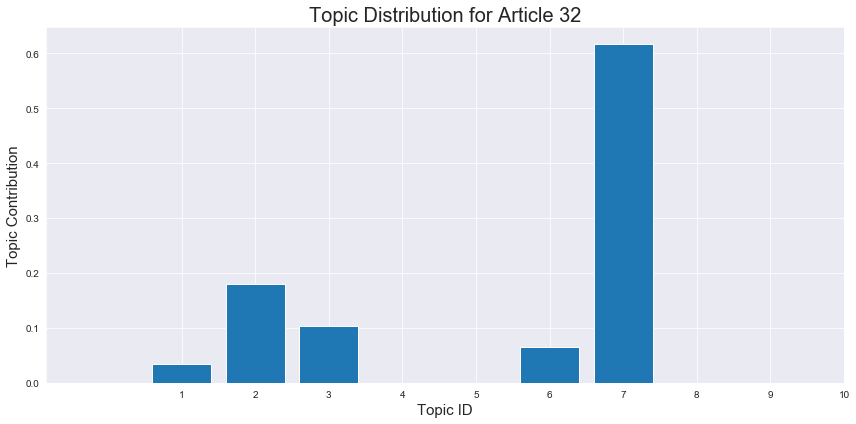

In [48]:
# bar plot of topic distribution for this document
fig, ax = plt.subplots(figsize=(12,6));
# the histogram of the data
patches = ax.bar(np.arange(len(doc_distribution)), doc_distribution)
ax.set_xlabel('Topic ID', fontsize=15)
ax.set_ylabel('Topic Contribution', fontsize=15)
ax.set_title("Topic Distribution for Article " + str(cool_article_index), fontsize=20)
ax.set_xticks(np.linspace(1,10,10))
fig.tight_layout()
plt.show()

In [49]:
for i in doc_distribution.argsort()[-5:][::-1]:
    print(i, lda.show_topic(topicid=i, topn=10), "\n")

7 [('student', 0.03533339), ('teacher', 0.023173422), ('use', 0.021455618), ('classroom', 0.012671542), ('practic', 0.01247882), ('teach', 0.011781198), ('mathemat', 0.0111406455), ('studi', 0.010221786), ('learn', 0.009960753), ('develop', 0.009585784)] 

2 [('scienc', 0.041252997), ('student', 0.028977867), ('stem', 0.01910157), ('cultur', 0.015633598), ('program', 0.015081083), ('classroom', 0.013559717), ('practic', 0.012408083), ('teach', 0.011572906), ('particip', 0.010664709), ('studi', 0.00987815)] 

3 [('research', 0.020174567), ('learn', 0.015434589), ('practic', 0.015070501), ('student', 0.0149603635), ('paper', 0.012592308), ('natur', 0.012459442), ('write', 0.012092107), ('art', 0.012062704), ('content', 0.011838984), ('framework', 0.011814588)] 

6 [('teacher', 0.033356708), ('practic', 0.017946083), ('learn', 0.0152946515), ('profession', 0.0149480095), ('develop', 0.014494566), ('studi', 0.013497489), ('support', 0.012178685), ('teach', 0.011898137), ('student', 0.01029

In [50]:
# select and article at random from test_df
random_article_index = np.random.randint(len(test_df))
print(random_article_index)

22


In [51]:
new_bow = dictionary.doc2bow(test_df.iloc[random_article_index,6])

In [52]:
print(test_df.iloc[random_article_index,3])

Abstract: The push for STEM has raised the visibility of engineering as a discipline that all students should learn. With the release of the Framework for K‐12 Science Education and the Next Generation Science Standards (NGSS), engineering now has an official place in the science curriculum. In both the Framework and the NGSS, engineering is framed as a way to solve the world's greatest problems. Despite this potential, there are troubling aspects in the way that the Framework and NGSS present engineering and how engineering is taken up in the curriculum. In this article, we use critiques of technocracy, utilitarianism, and neoliberalism to analyze the portrayal of engineering in the Framework and NGSS. We claim that the Framework and NGSS promote a technocratic perspective that engineered solutions can all problems, ignoring the socio‐political foundations of many of the world's most pressing problems. Furthermore, both standards documents reflect a utilitarian ethic that promotes all

In [53]:
new_doc_distribution = np.array([tup[1] for tup in lda.get_document_topics(bow=new_bow)])

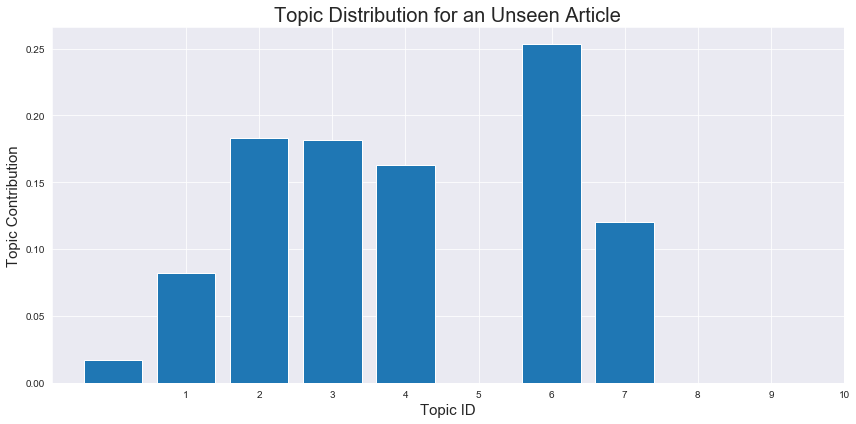

In [54]:
# bar plot of topic distribution for this document
fig, ax = plt.subplots(figsize=(12,6));
# the histogram of the data
patches = ax.bar(np.arange(len(new_doc_distribution)), new_doc_distribution)
ax.set_xlabel('Topic ID', fontsize=15)
ax.set_ylabel('Topic Contribution', fontsize=15)
ax.set_title("Topic Distribution for an Unseen Article", fontsize=20)
ax.set_xticks(np.linspace(1,10,10))
fig.tight_layout()
plt.show()

In [55]:
# print the top 8 contributing topics and their words
for i in new_doc_distribution.argsort()[-5:][::-1]:
    print(i, lda.show_topic(topicid=i, topn=10), "\n")

6 [('teacher', 0.033356708), ('practic', 0.017946083), ('learn', 0.0152946515), ('profession', 0.0149480095), ('develop', 0.014494566), ('studi', 0.013497489), ('support', 0.012178685), ('teach', 0.011898137), ('student', 0.010299086), ('research', 0.009919488)] 

2 [('scienc', 0.041252997), ('student', 0.028977867), ('stem', 0.01910157), ('cultur', 0.015633598), ('program', 0.015081083), ('classroom', 0.013559717), ('practic', 0.012408083), ('teach', 0.011572906), ('particip', 0.010664709), ('studi', 0.00987815)] 

3 [('research', 0.020174567), ('learn', 0.015434589), ('practic', 0.015070501), ('student', 0.0149603635), ('paper', 0.012592308), ('natur', 0.012459442), ('write', 0.012092107), ('art', 0.012062704), ('content', 0.011838984), ('framework', 0.011814588)] 

4 [('practic', 0.017621266), ('student', 0.01651952), ('educ', 0.01570885), ('learn', 0.014833007), ('school', 0.014764982), ('polici', 0.012830897), ('research', 0.012826172), ('children', 0.011732512), ('pupil', 0.01142

In [56]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda, corpus, dictionary)
vis

c:\python37-32\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.042211  0.010705       1        1  23.051729
6     -0.010892 -0.001453       2        1  19.336159
4     -0.069374 -0.044725       3        1  14.598916
2     -0.037686 -0.020608       4        1  13.945931
1     -0.073235  0.031260       5        1  10.847373
3     -0.000312  0.072870       6        1   8.793563
8     -0.101542 -0.217560       7        1   5.389418
0     -0.007310  0.232345       8        1   3.251998
5      0.342561 -0.062834       9        1   0.784923, topic_info=     Category        Freq            Term       Total  loglift  logprob
187   Default  596.000000         teacher  596.000000  30.0000  30.0000
46    Default  185.000000          social  185.000000  29.0000  29.0000
399   Default   83.000000         languag   83.000000  28.0000  28.0000
50    Default  371.000000           teach  371.000000  27.0000  27.0000
294   Default  827.000000         student  827.000000  26.0000  26.0000
562   Default  112.000000            make  112.000000  25.0000  25.0000
645   Default   69.000000           proof   69.000000  24.0000  24.0000
9     Default  313.000000         develop  313.000000  23.0000  23.0000
43    Default  410.000000          scienc  410.000000  22.0000  22.0000
86    Default  189.000000        mathemat  189.000000  21.0000  21.0000
172   Default   77.000000          lesson   77.000000  20.0000  20.0000
246   Default  207.000000          school  207.000000  19.0000  19.0000
55    Default  366.000000             use  366.000000  18.0000  18.0000
574   Default  152.000000        children  152.000000  17.0000  17.0000
2     Default  150.000000          assess  150.000000  16.0000  16.0000
372   Default  135.000000            stem  135.000000  15.0000  15.0000
49    Default  343.000000           studi  343.000000  14.0000  14.0000
24    Default   70.000000          justic   70.000000  13.0000  13.0000
27    Default  157.000000            math  157.000000  12.0000  12.0000
33    Default  518.000000         practic  518.000000  11.0000  11.0000
214   Default  123.000000           engag  123.000000  10.0000  10.0000
185   Default  164.000000         support  164.000000   9.0000   9.0000
257   Default  127.000000          achiev  127.000000   8.0000   8.0000
509   Default   74.000000         describ   74.000000   7.0000   7.0000
208   Default  130.000000          cultur  130.000000   6.0000   6.0000
35    Default   47.000000         qualiti   47.000000   5.0000   5.0000
346   Default   51.000000           engin   51.000000   4.0000   4.0000
1539  Default   62.000000           pupil   62.000000   3.0000   3.0000
229   Default  423.000000           learn  423.000000   2.0000   2.0000
255   Default   29.000000           youth   29.000000   1.0000   1.0000
...       ...         ...             ...         ...      ...      ...
1685   Topic9    0.917448        stemrich    2.291547   3.9320  -5.7625
1620   Topic9    0.046387       himexpert    0.117748   3.9158  -8.7470
1478   Topic9    3.493172           figur    9.446307   3.8525  -4.4255
778    Topic9    0.038298           civil    0.108743   3.8038  -8.9386
1624   Topic9    0.034515        placeand    0.107297   3.7131  -9.0426
792    Topic9    0.033229  preandinservic    0.104325   3.7032  -9.0806
1627   Topic9    0.032085       territori    0.105047   3.6613  -9.1157
921    Topic9    0.030862       unsuccess    0.103762   3.6348  -9.1545
1052   Topic9    1.716000           maker    5.960188   3.6022  -5.1363
1418   Topic9    1.846102            rich    6.445286   3.5971  -5.0632
255    Topic9    8.430636           youth   29.782673   3.5853  -3.5444
440    Topic9    4.637350             six   16.402618   3.5840  -4.1422
399    Topic9   22.024532         languag   83.422928   3.5156  -2.5841
759    Topic9    0.553141          leader    2.637302   3.2854  -6.2684
1243   Topic9    3.131206            upon   25.8358

In [58]:
pyLDAvis.save_html(vis, 'vis6.html')

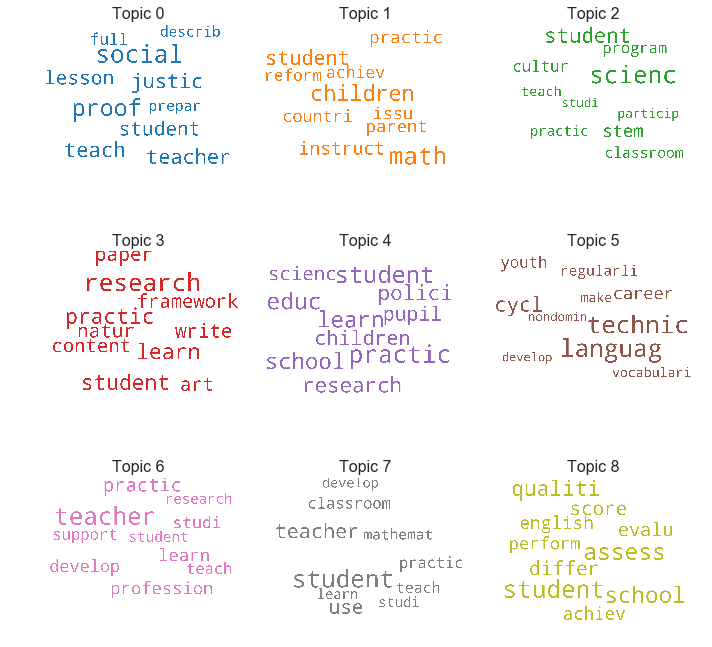

<Figure size 432x288 with 0 Axes>

In [59]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda.show_topics(formatted=False)

fig, axes = plt.subplots(3, 3, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

plt.savefig('topics.png', transparent=True)

In [61]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=all_words):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda, corpus=corpus, texts=all_words)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Article_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Most_Common_Word']
df_dominant_topic.head(10)

,Article_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Most_Common_Word
0,0,2.0,0.9991,"scienc, student, stem, cultur, program, classr...",studi
1,1,3.0,0.8218,"research, learn, practic, student, paper, natu...",assess
2,2,3.0,0.8355,"research, learn, practic, student, paper, natu...",reliabl
3,3,1.0,0.3203,"math, children, student, instruct, practic, pa...",two
4,4,4.0,0.4877,"practic, student, educ, learn, school, polici,...",observ
5,5,1.0,0.3774,"math, children, student, instruct, practic, pa...",rubric
6,6,6.0,0.9989,"teacher, practic, learn, profession, develop, ...",one
7,7,2.0,0.2973,"scienc, student, stem, cultur, program, classr...",math
8,8,7.0,0.7297,"student, teacher, use, classroom, practic, tea...",scienc
9,9,5.0,0.5360,"languag, technic, cycl, career, youth, regular...",document


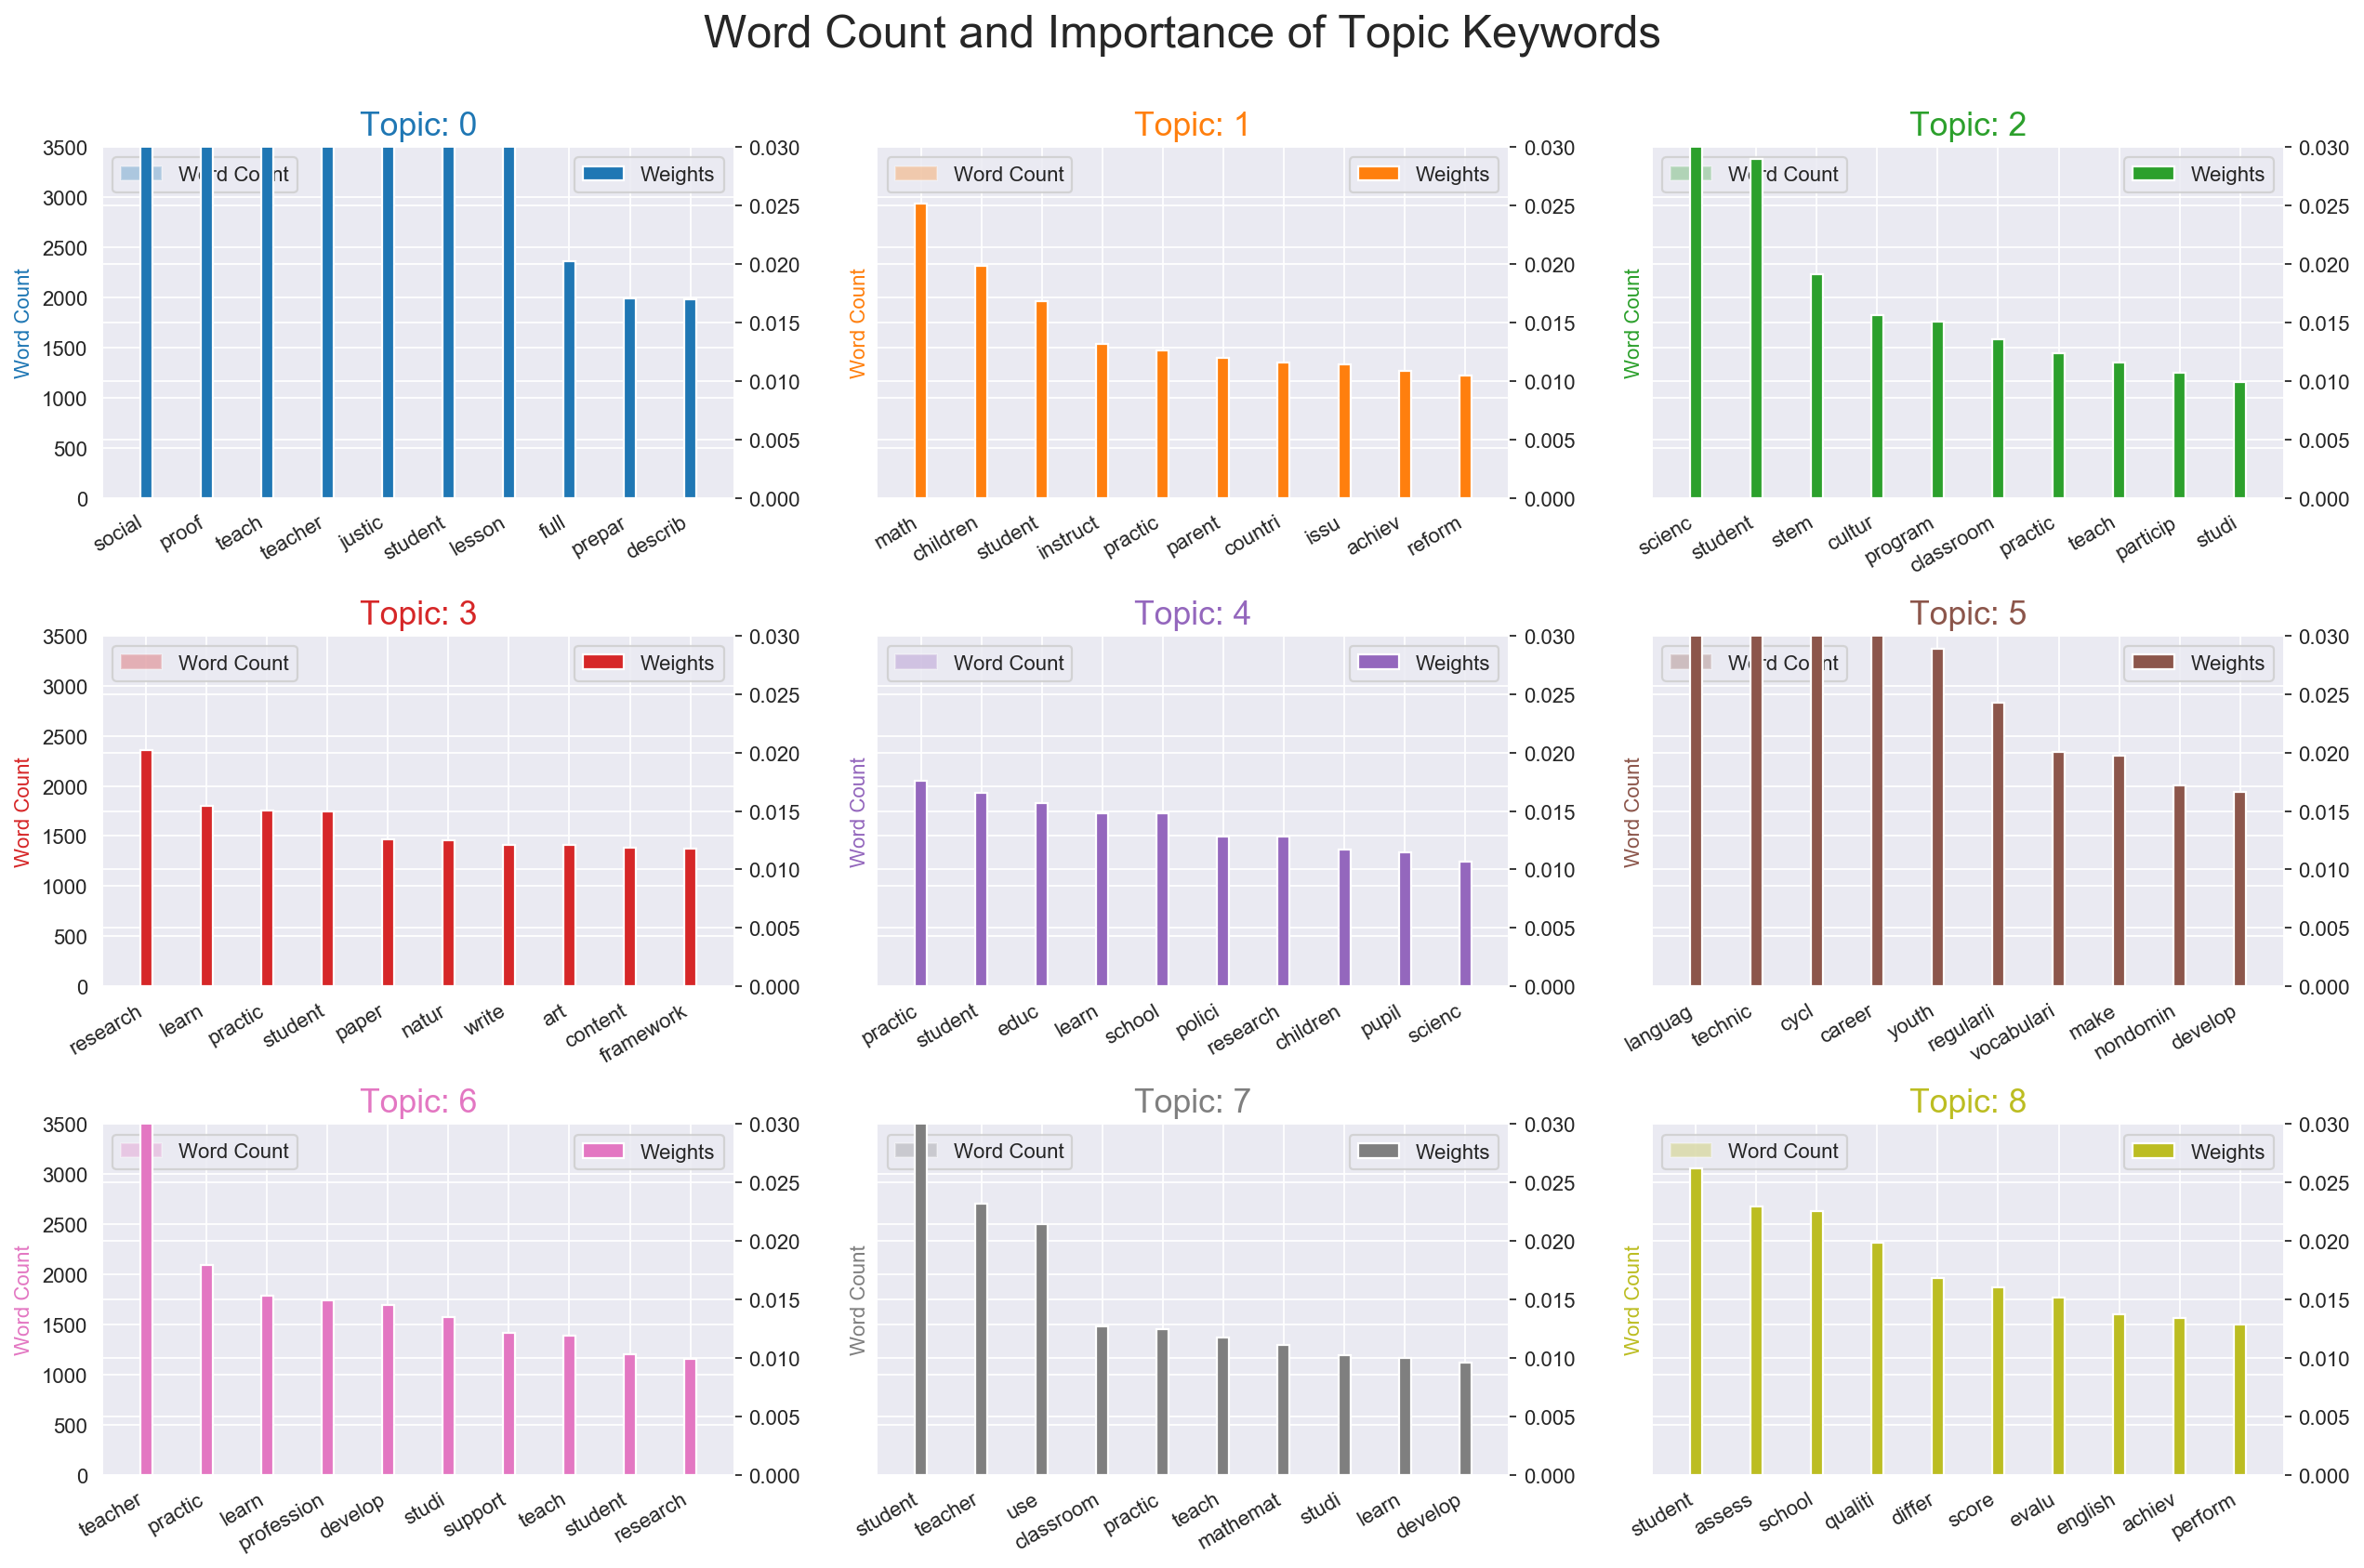

In [62]:
from collections import Counter
topics = lda.show_topics(formatted=False)
data_flat = [w for w_list in all_words for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(3, 3, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

ValueError: too many values to unpack (expected 3)

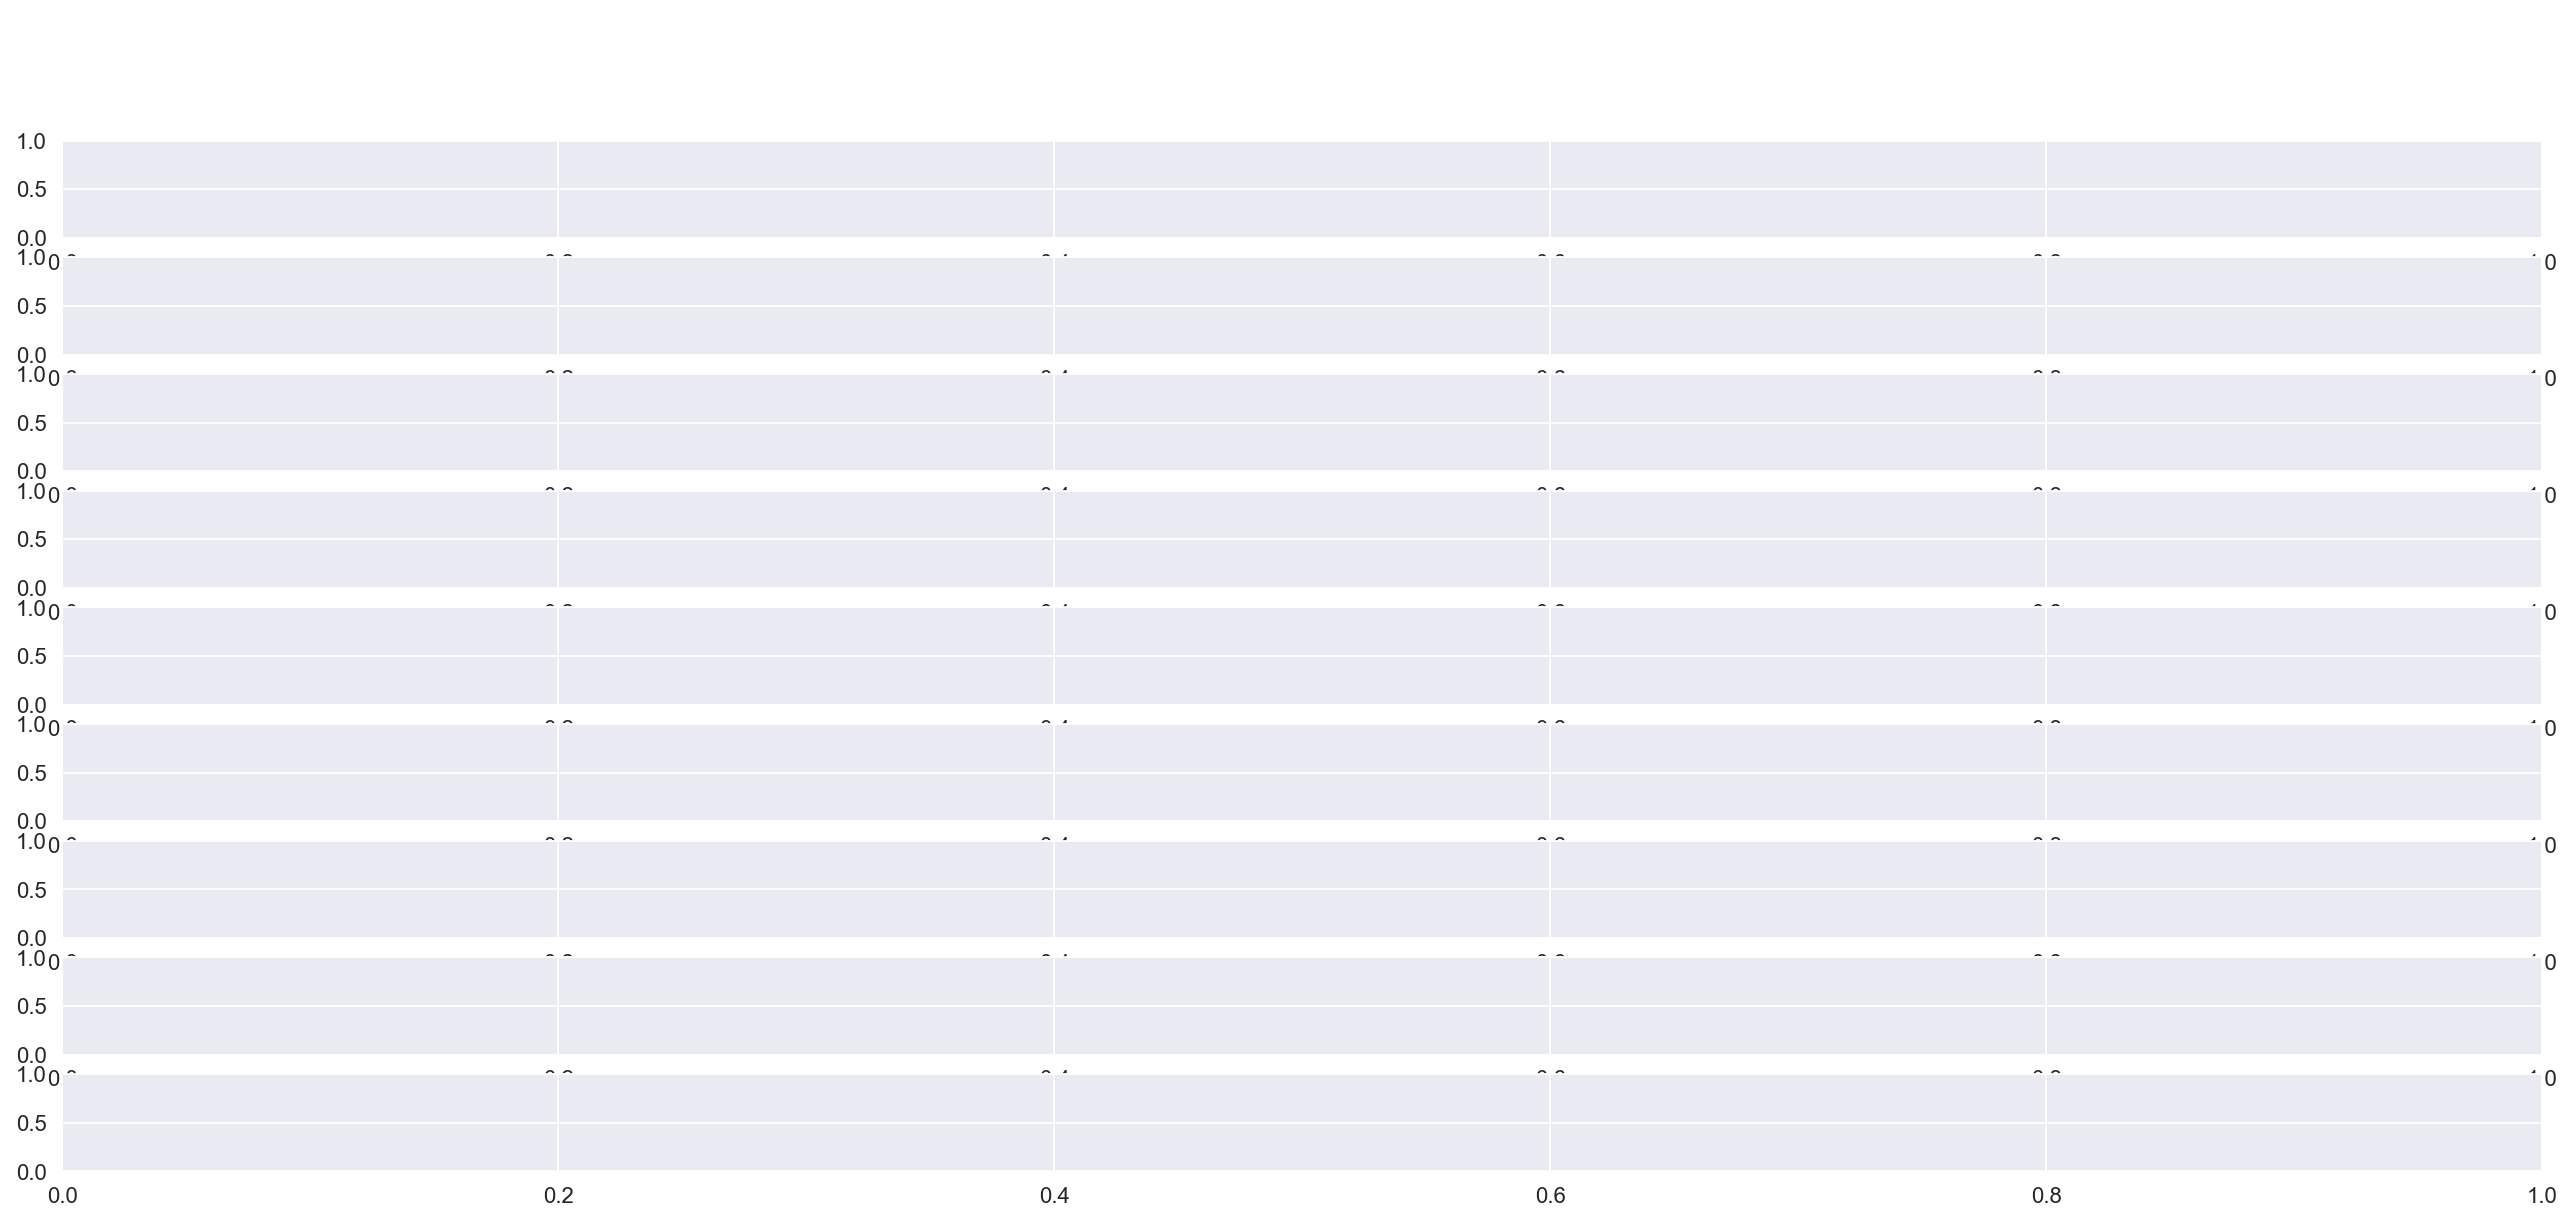

In [67]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda=lda, corpus=corpus, start = 0, end = 10):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()

In [71]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = 'path/to/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=dictionary)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\18059\\AppData\\Local\\Temp\\b3c03a_state.mallet.gz'

In [68]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

TypeError: cannot unpack non-iterable int object

# num_topics = 10
chunksize = 300
dictionary = corpora.Dictionary(df['tokenized_abstracts'])
corpus = [dictionary.doc2bow(doc) for doc in df['tokenized_abstracts']]
t1 = time.time()
    # low alpha means each document is only represented by a small number of topics, and vice versa
    # low eta means each topic is only represented by a small number of words, and vice versa
hdp = HdpModel(corpus=corpus, num_topics=num_topics, id2word=dictionary,
      alpha=1e-2, eta=0.5e-2, chunksize=chunksize, minimum_probability=0.0, passes=2)

In [ ]:
cm = CoherenceModel(model=model, corpus=common_corpus, coherence='u_mass')

In [107]:
# we need to use nested list comprehension here
# this may take 1-2 minutes...
doc_topic_dist = np.array([[tup[1] for tup in lst] for lst in lda[corpus]])
doc_topic_dist.shape

(165, 10)

In [108]:
def jensen_shannon(query, matrix):
    """
    This function implements a Jensen-Shannon similarity
    between the input query (an LDA topic distribution for a document)
    and the entire corpus of topic distributions.
    It returns an array of length M where M is the number of documents in the corpus
    """
    # lets keep with the p,q notation above
    p = query[None,:].T # take transpose
    q = matrix.T # transpose matrix
    m = 0.5*(p + q)
    return np.sqrt(0.5*(entropy(p,m) + entropy(q,m)))

In [109]:
def get_most_similar_documents(query,matrix,k=10):
    """
    This function implements the Jensen-Shannon distance above
    and retruns the top k indices of the smallest jensen shannon distances
    """
    sims = jensen_shannon(query,matrix) # list of jensen shannon distances
    return sims.argsort()[:k] # the top k positional index of the smallest Jensen Shannon distances

In [110]:
# this is surprisingly fast
most_sim_ids = get_most_similar_documents(new_doc_distribution,doc_topic_dist)

In [117]:
most_similar_df = train_df[train_df.index.isin(most_sim_ids)]
most_similar_df[['Article_Title', 'Authors']]

,Article_Title,Authors
19,Towards a local integration of theories: codes...,"['Gellert, Uwe', 'Barbé, Joaquim', 'Espinoza, ..."
32,Equity in Mathematics Education.,nan
36,Positioning in mathematics education: revelati...,"['Herbel-Eisenmann, Beth', 'Wagner, David', 'J..."
45,Use and exchange value in mathematics educatio...,"Williams, Julian"
105,Additional Resources for Classroom Use.,nan
133,This Issue.,"['Turner, Julianne C.', 'Meyer, Debra K.', 'Pa..."
140,Detracking and Heterogeneous Grouping /,"Rubin, Beth C."
141,"Tracking and Detracking: Debates, Evidence, an...","Rubin, Beth C."
144,Integrating Multicultural and Gifted Education...,"['Ford, Donna Y.', 'Moore, James L.', 'Harmon,..."
147,Preparing Educational Leaders to Close Achieve...,"['Johnson, Joseph F.', 'Uline, Cynthia L.']"
